## Dataset Used  
[LFW (Labelled Faces in the Wild)](https://www.kaggle.com/learn)

In [1]:
from pathlib import Path
dataset_path = Path("./lfw")

matchpairs_train_csv = dataset_path / "matchpairsDevTrain.csv"
assert matchpairs_train_csv.exists(), f"Expected {matchpairs_train_csv} to exist."


mismatches_train_csv = dataset_path / "mismatchpairsDevTrain.csv"
assert mismatches_train_csv.exists(), f"Expected {mismatches_train_csv} to exist."

matchpairs_test_csv = dataset_path / "matchpairsDevTest.csv"
assert matchpairs_test_csv.exists(), f"Expected {matchpairs_test_csv} to exist."

mismatches_test_csv = dataset_path / "mismatchpairsDevTest.csv"
assert mismatches_test_csv.exists(), f"Expected {mismatches_test_csv} to exist."

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import os
from sklearn.metrics import accuracy_score, classification_report
import random

In [3]:
import tensorflow as tf

# Check GPU availability
print("GPU Available: ", tf.config.list_physical_devices("GPU"))
print("Built with CUDA: ", tf.test.is_built_with_cuda())

# Check what device TensorFlow is using
if tf.config.list_physical_devices("GPU"):
    print("TensorFlow is using GPU")
    # Force GPU usage (optional)
    with tf.device("/GPU:0"):
        # Your model training code here
        pass
else:
    print("TensorFlow is using CPU")

GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Built with CUDA:  False
TensorFlow is using GPU


2025-09-09 11:24:21.576423: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-09-09 11:24:21.576470: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-09-09 11:24:21.576480: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-09-09 11:24:21.576677: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-09-09 11:24:21.576697: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
# Configuration
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

MATCH_HEADERS = ["name", "imagenum1", "imagenum2"]
MISMATCH_HEADERS = ["name1", "imagenum1", "name2", "imagenum2"]


def get_image_path(person_name, image_num):
    """Get the path to an image given person name and image number"""
    img_name = f"{person_name}_{image_num:04d}.jpg"
    return (
        dataset_path / "lfw-deepfunneled" / "lfw-deepfunneled" / person_name / img_name
    )

def load_pairs_data(csv_file, is_match=True):
    """Load pairs data from CSV file"""
    df = pd.read_csv(
        csv_file, header=0, names=MATCH_HEADERS if is_match else MISMATCH_HEADERS
    )
    pairs = []
    labels = []

    for index, row in df.iterrows():
        # Match pairs: same person, different images
        if is_match:
            name = row["name"]
            img1_path = get_image_path(name, row["imagenum1"])
            img2_path = get_image_path(name, row["imagenum2"])
            label = 1  # Same person
        else:
            # Mismatch pairs: different persons
            name1 = row["name1"]
            name2 = row["name2"]
            img1_path = get_image_path(name1, row["imagenum1"])
            img2_path = get_image_path(name2, row["imagenum2"])
            label = 0

        pairs.append((img1_path, img2_path))
        labels.append(label)

    return pairs, labels

In [5]:
match_pairs_train, match_labels_train = load_pairs_data(matchpairs_train_csv, is_match=True)
mismatch_pairs_train, mismatch_labels_train = load_pairs_data(mismatches_train_csv, is_match=False)

match_pairs_test, match_labels_test = load_pairs_data(matchpairs_test_csv, is_match=True)
mismatch_pairs_test, mismatch_labels_test = load_pairs_data(mismatches_test_csv, is_match=False)

matched_pairs = match_pairs_train + match_pairs_test
matched_labels = match_labels_train + match_labels_test

mismatched_pairs = mismatch_pairs_train + mismatch_pairs_test
mismatched_labels = mismatch_labels_train + mismatch_labels_test

all_pairs = matched_pairs + mismatched_pairs
all_labels = matched_labels + mismatched_labels
print(f"Total pairs: {len(all_pairs)}, Matches: {sum(all_labels)}, Mismatches: {len(all_labels) - sum(all_labels)}")

Total pairs: 3200, Matches: 1600, Mismatches: 1600


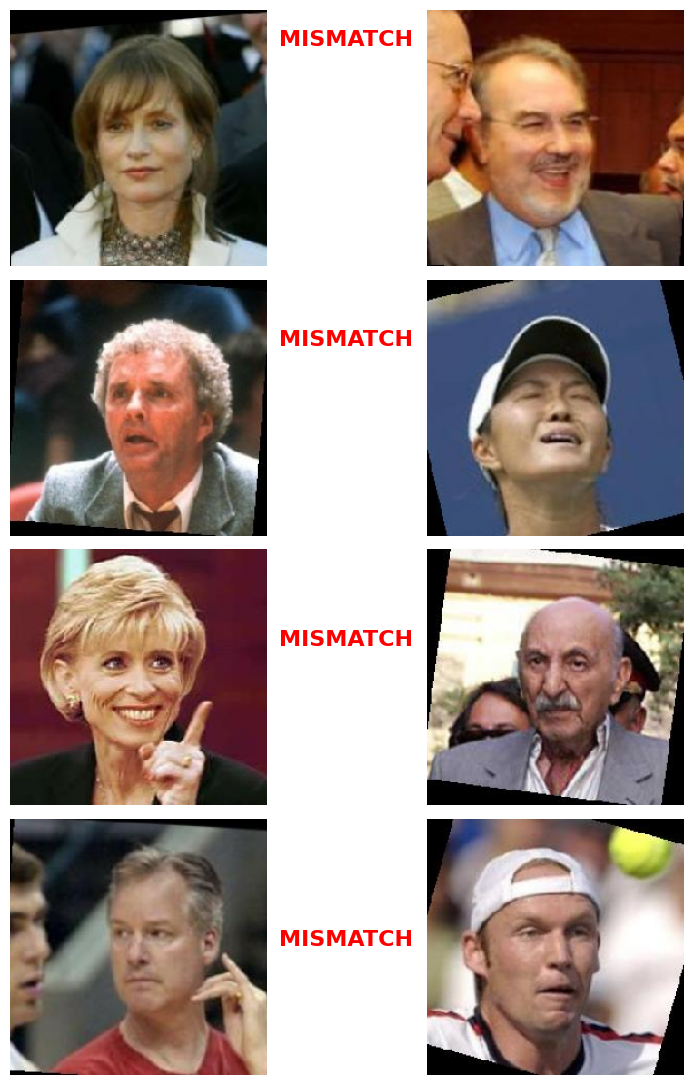

In [6]:
import numpy as np


def visualize_pairs(pairs, labels):
    n_pairs = len(pairs)
    fig, axes = plt.subplots(nrows=n_pairs, ncols=2, figsize=(10, 3 * n_pairs))

    # Handle single pair case
    if n_pairs == 1:
        axes = axes.reshape(1, 2)

    for i, (pair, label) in enumerate(zip(pairs, labels)):
        img1 = img_to_array(load_img(pair[0], target_size=IMG_SIZE)) / 255.0
        img2 = img_to_array(load_img(pair[1], target_size=IMG_SIZE)) / 255.0

        # Determine label and color
        label_text = "MATCH" if label == 1 else "MISMATCH"
        color = "green" if label == 1 else "red"

        axes[i, 0].imshow(img1)
        axes[i, 0].axis("off")

        axes[i, 1].imshow(img2)
        axes[i, 1].axis("off")

        # Add colored borders
        for ax in [axes[i, 0], axes[i, 1]]:
            for spine in ax.spines.values():
                spine.set_visible(True)
                spine.set_edgecolor(color)
                spine.set_linewidth(3)

        # Add text between images for each pair
        fig.text(
            0.5,
            1 - (i + 0.5) / n_pairs,
            f"{label_text}",
            ha="center",
            va="center",
            fontsize=16,
            fontweight="bold",
            color=color,
            transform=fig.transFigure,
        )

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # Make room for text
    plt.show()


random_indices = random.sample(range(len(all_pairs)), 4)
pairs = [all_pairs[i] for i in random_indices]
labels = [all_labels[i] for i in random_indices]
visualize_pairs(pairs, labels)

In [7]:
def load_and_preprocess_image(image_path):
    """Load and preprocess an image"""
    try:
        # Load image
        img = load_img(image_path, target_size=IMG_SIZE)
        img_array = img_to_array(img)
        # Normalize to [0,1]
        img_array = img_array / 255.0
        return img_array
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        # Return a black image if loading fails
        return np.zeros((*IMG_SIZE, 3))

In [8]:
import random
import tensorflow as tf


def create_tf_dataset(
    pairs,
    labels,
    batch_size=32,
    shuffle=True,
    buffer_size=None,  # if None, will default to len(pairs) when shuffling
):
    """
    Create a tf.data.Dataset of ((img1, img2), label) where:
      - img1/img2: float32 tensors of shape (H, W, 3)
      - label: float32
    """


    def generator():
        indices = list(range(len(pairs)))
        if shuffle:
            random.shuffle(indices)

        for i in indices:
            img1_path, img2_path = pairs[i]
            y = labels[i]

            # Must return float32 of shape (H, W, 3)
            img1 = load_and_preprocess_image(
                img1_path
            )  # ensure it outputs (H,W,3) float32
            img2 = load_and_preprocess_image(img2_path)

            # Ensure label is float32 and shape (1,)
            y = tf.cast(y, tf.float32)
            y = tf.reshape(y, (1,))  # or keep scalar if your loss expects that

            yield (img1, img2), y

    output_signature = (
        (
            tf.TensorSpec(shape=(*IMG_SIZE, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(*IMG_SIZE, 3), dtype=tf.float32),
        ),
        tf.TensorSpec(shape=(1,), dtype=tf.float32),
    )

    dataset = tf.data.Dataset.from_generator(
        generator, output_signature=output_signature
    )

    if shuffle:
        if buffer_size is None:
            buffer_size = len(pairs)
        dataset = dataset.shuffle(
            buffer_size=buffer_size, reshuffle_each_iteration=True
        )

    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [9]:
def create_tf_dataset_optimized(pairs, labels, batch_size=32, shuffle=True):
    """Optimized dataset creation without generators"""

    def load_image_pair(img1_path, img2_path):
        """Load and preprocess image pair"""
        img1 = tf.io.read_file(img1_path)
        img1 = tf.image.decode_jpeg(img1, channels=3)
        img1 = tf.image.resize(img1, IMG_SIZE)
        img1 = tf.cast(img1, tf.float32) / 255.0

        img2 = tf.io.read_file(img2_path)
        img2 = tf.image.decode_jpeg(img2, channels=3)
        img2 = tf.image.resize(img2, IMG_SIZE)
        img2 = tf.cast(img2, tf.float32) / 255.0

        return (img1, img2)

    # Convert paths to string tensors
    img1_paths = [str(pair[0]) for pair in pairs]
    img2_paths = [str(pair[1]) for pair in pairs]

    # Create datasets
    path_dataset = tf.data.Dataset.from_tensor_slices((img1_paths, img2_paths))
    label_dataset = tf.data.Dataset.from_tensor_slices(labels)

    # Combine and process
    dataset = tf.data.Dataset.zip((path_dataset, label_dataset))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(pairs), reshuffle_each_iteration=True)

    # Map the loading function - FIXED LAMBDA
    dataset = dataset.map(
        lambda path_pair, label: (
            load_image_pair(path_pair[0], path_pair[1]),
            tf.cast(label, tf.float32),
        ),
        num_parallel_calls=tf.data.AUTOTUNE,
    )

    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [10]:
from sklearn.model_selection import train_test_split
train_pairs, validation_pairs, train_labels, validation_labels = train_test_split(
    all_pairs, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)
validation_pairs, test_pairs, validation_labels, test_labels = train_test_split(
    validation_pairs, validation_labels, test_size=0.5, random_state=42, stratify=validation_labels
)
print(f"Train pairs: {len(train_pairs)}, Validation pairs: {len(validation_pairs)}, Test pairs: {len(test_pairs)}")
print(f"Train matches: {sum(train_labels)}, Validation matches: {sum(validation_labels)}, Test matches: {sum(test_labels)}")
print(f"Train mismatches: {len(train_labels) - sum(train_labels)}, Validation mismatches: {len(validation_labels) - sum(validation_labels)}, Test mismatches: {len(test_labels) - sum(test_labels)}")

Train pairs: 2560, Validation pairs: 320, Test pairs: 320
Train matches: 1280, Validation matches: 160, Test matches: 160
Train mismatches: 1280, Validation mismatches: 160, Test mismatches: 160


In [11]:
# Use the fixed optimized function for all datasets
train_dataset = create_tf_dataset_optimized(
    train_pairs, train_labels, batch_size=BATCH_SIZE, shuffle=True
)
validation_dataset = create_tf_dataset_optimized(
    validation_pairs, validation_labels, batch_size=BATCH_SIZE, shuffle=False
)
test_dataset = create_tf_dataset_optimized(
    test_pairs, test_labels, batch_size=BATCH_SIZE, shuffle=False
)

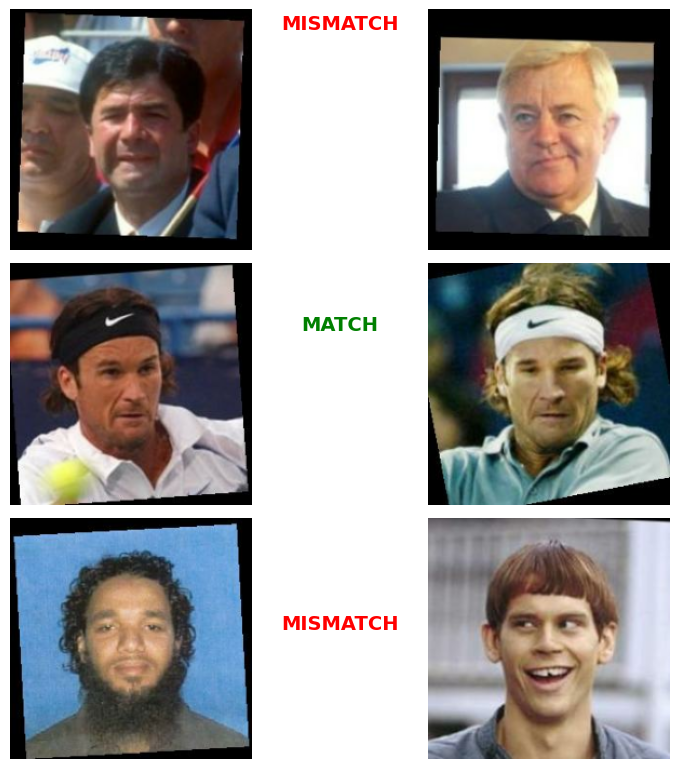

Batch size: 32
Image shapes: (32, 224, 224, 3)
Labels: [0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0.
 1. 0. 0. 1. 0. 0. 1. 1.]


In [12]:
def visualize_single_batch(dataset, num_pairs_to_show=3):
    """Visualize a few pairs from a single batch"""

    # Take one batch
    for batch_pairs, batch_labels in dataset.take(1):
        img1_batch, img2_batch = batch_pairs

        # Show only first few pairs from the batch
        n = min(num_pairs_to_show, len(batch_labels))

        fig, axes = plt.subplots(n, 2, figsize=(10, n * 3))
        if n == 1:
            axes = axes.reshape(1, 2)

        for i in range(n):
            img1 = img1_batch[i].numpy()
            img2 = img2_batch[i].numpy()
            label = int(batch_labels[i].numpy())

            label_text = "MATCH" if label == 1 else "MISMATCH"
            color = "green" if label == 1 else "red"

            axes[i, 0].imshow(np.clip(img1, 0, 1))
            axes[i, 0].axis("off")

            axes[i, 1].imshow(np.clip(img2, 0, 1))
            axes[i, 1].axis("off")

            # Add colored borders
            for ax in [axes[i, 0], axes[i, 1]]:
                for spine in ax.spines.values():
                    spine.set_visible(True)
                    spine.set_edgecolor(color)
                    spine.set_linewidth(3)

            # Add label text
            fig.text(
                0.5,
                1 - (i + 0.5) / n,
                f"{label_text}",
                ha="center",
                va="center",
                fontsize=14,
                fontweight="bold",
                color=color,
                transform=fig.transFigure,
            )

        plt.tight_layout()
        plt.subplots_adjust(top=0.85)
        plt.show()

        print(f"Batch size: {len(batch_labels)}")
        print(f"Image shapes: {img1_batch.shape}")
        print(f"Labels: {batch_labels.numpy().flatten()}")
        break


# Use it
visualize_single_batch(train_dataset, num_pairs_to_show=3)

### Model building

In [13]:
def contrastive_loss(
    y_true, y_pred, margin=0.3
):  # Smaller margin for cosine distance
    """Contrastive loss specifically for cosine distance [0, 0.5]"""
    y_true = tf.cast(y_true, tf.float32)

    # For positive pairs (same person): minimize distance
    positive_loss = y_true * tf.square(y_pred)

    # For negative pairs (different people): maximize distance up to margin
    # Since cosine distance is in [0, 0.5], margin should be ~0.3-0.4
    negative_loss = (1 - y_true) * tf.square(tf.maximum(0.0, margin - y_pred))

    return tf.reduce_mean(positive_loss + negative_loss)


def hard_negative_contrastive_loss(y_true, y_pred, margin=1.5, alpha=3.0):
    """Contrastive loss that focuses on hard negatives (close different people)"""
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.squeeze(y_pred)

    # Standard positive loss
    positive_loss = y_true * tf.square(y_pred)

    # Hard negative loss - punish negative pairs that are too close
    negative_mask = 1 - y_true
    hard_negative_penalty = tf.where(
        y_pred < margin,  # If negative pairs are closer than margin
        alpha * tf.square(margin - y_pred),  # Apply extra penalty
        tf.square(tf.maximum(0.0, margin - y_pred)),  # Standard penalty
    )
    negative_loss = negative_mask * hard_negative_penalty

    return tf.reduce_mean(positive_loss + negative_loss)


def enhanced_hard_negative_contrastive_loss(
    y_true, y_pred, margin=1.5, alpha=3.0, beta=1.5
):
    """Enhanced contrastive loss with stronger separation"""
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.squeeze(y_pred)

    # For positive pairs: minimize distance with extra penalty for far pairs
    positive_loss = y_true * (tf.square(y_pred) + beta * tf.maximum(0.0, y_pred - 0.5))

    # For negative pairs: much stronger penalty for close pairs
    negative_mask = 1 - y_true
    hard_negative_penalty = tf.where(
        y_pred < margin,  # If negative pairs are closer than margin
        alpha * tf.square(margin - y_pred)
        + tf.exp(margin - y_pred),  # Exponential penalty
        tf.square(tf.maximum(0.0, margin - y_pred)),  # Standard penalty
    )
    negative_loss = negative_mask * hard_negative_penalty

    return tf.reduce_mean(positive_loss + negative_loss)


def accuracy_metric(y_true, y_pred, threshold=0.5):
    """
    Custom accuracy metric for Siamese networks.
    Predictions below threshold are considered same person.
    """
    y_true = tf.cast(y_true, tf.float32)
    predictions = tf.cast(y_pred < threshold, tf.float32)
    return tf.reduce_mean(tf.cast(tf.equal(y_true, predictions), tf.float32))

In [14]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Define callbacks
callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True,
        verbose=1,
        min_delta=0.0001,
    ),
    ReduceLROnPlateau(
        monitor="val_loss", factor=0.8, patience=5, min_lr=1e-8, verbose=1
    ),
]

In [15]:
def evaluate_model(model, test_dataset, threshold=0.5):
    """Evaluate the model on test data"""
    predictions = model.predict(test_dataset)

    # Get true labels
    true_labels = []
    for _, labels in test_dataset:
        true_labels.extend(labels.numpy().flatten())

    true_labels = np.array(true_labels)
    predicted_labels = (predictions.flatten() < threshold).astype(int)

    # Calculate metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    report = classification_report(
        true_labels, predicted_labels, target_names=["Different", "Same"]
    )

    print(f"Test Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(report)

    return predictions, true_labels, predicted_labels

In [16]:
def preprocess_single_image(image_path):
    """Preprocess a single image for prediction"""
    img = load_and_preprocess_image(image_path)
    return np.expand_dims(img, axis=0)


def compare_faces(model, img1_path, img2_path, threshold=0.5):
    """
    Compare two face images and return similarity score
    """
    # Preprocess images
    img1 = preprocess_single_image(img1_path)
    img2 = preprocess_single_image(img2_path)

    # Predict distance
    distance = model.predict([img1, img2])[0][0]

    # Determine if same person
    is_same_person = distance < threshold

    return {
        "distance": distance,
        "is_same_person": is_same_person,
        "threshold": threshold,
    }


def visualize_prediction(img1_path, img2_path, result):
    """Visualize prediction result"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Load and display images
    img1 = np.array(load_and_preprocess_image(img1_path))
    img2 = np.array(load_and_preprocess_image(img2_path))

    ax1.imshow(np.clip(img1, 0, 1))
    ax1.set_title("Image 1", fontsize=14, fontweight="bold")
    ax1.axis("off")

    ax2.imshow(np.clip(img2, 0, 1))
    ax2.set_title("Image 2", fontsize=14, fontweight="bold")
    ax2.axis("off")

    # Add result text
    color = "green" if result["is_same_person"] else "red"
    result_text = "SAME PERSON" if result["is_same_person"] else "DIFFERENT PERSONS"

    plt.suptitle(
        f"{result_text}\nDistance: {result['distance']:.3f}",
        fontsize=16,
        fontweight="bold",
        color=color,
    )

    # Add colored borders
    for ax in (ax1, ax2):
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_edgecolor(color)
            spine.set_linewidth(3)

    plt.tight_layout()
    plt.show()

In [17]:
from tensorflow.keras.applications import ResNet50, VGG16, EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    Dense,
    Lambda,
    BatchNormalization,
    Dropout,
    GlobalAveragePooling2D,
)
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K


def create_pretrained_base_network(
    input_shape, backbone="resnet50", trainable_layers=20  # Increased from 5
):
    """
    Create base network with more trainable layers
    """
    input_layer = Input(shape=input_shape)

    if backbone == "resnet50":
        base_model = ResNet50(
            weights="imagenet", include_top=False, input_tensor=input_layer
        )

    # First, freeze all layers
    for layer in base_model.layers:
        layer.trainable = False

    # Then selectively unfreeze only the layers we want, excluding BatchNorm
    total_layers = len(base_model.layers)
    start_trainable = max(0, total_layers - trainable_layers)

    for i, layer in enumerate(base_model.layers[start_trainable:], start_trainable):
        # Skip BatchNormalization and any normalization layers
        if isinstance(
            layer,
            (tf.keras.layers.BatchNormalization, tf.keras.layers.LayerNormalization),
        ):
            layer.trainable = False
        else:
            layer.trainable = True

    # Less aggressive regularization
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)  # Reduced from 0.5

    x = Dense(512, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)  # Reduced from 0.3

    x = Dense(256, activation="relu", name="embedding")(x)

    return Model(input_layer, x, name=f"{backbone}_base_network_more_trainable")


def create_enhanced_base_network(input_shape, backbone="resnet50", trainable_layers=25):
    """Enhanced base network with better feature extraction"""
    input_layer = Input(shape=input_shape)

    if backbone == "resnet50":
        base_model = ResNet50(
            weights="imagenet", include_top=False, input_tensor=input_layer
        )

    # Unfreeze more layers for better feature learning
    for layer in base_model.layers:
        layer.trainable = False

    total_layers = len(base_model.layers)
    start_trainable = max(0, total_layers - trainable_layers)

    for i, layer in enumerate(base_model.layers[start_trainable:], start_trainable):
        if isinstance(
            layer,
            (tf.keras.layers.BatchNormalization, tf.keras.layers.LayerNormalization),
        ):
            layer.trainable = False
        else:
            layer.trainable = True

    # Enhanced head with better feature extraction
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)

    # Larger embedding dimension for better separation
    x = Dense(1024, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    x = Dense(512, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    # Final embedding layer
    x = Dense(256, activation="relu", name="embedding")(x)

    return Model(input_layer, x, name=f"{backbone}_enhanced_base_network")

In [18]:
def cosine_similarity(vectors):
    """Improved cosine distance for face verification"""
    x, y = vectors

    # L2 normalize
    x_norm = K.l2_normalize(x, axis=1)
    y_norm = K.l2_normalize(y, axis=1)

    # Cosine similarity [-1, 1]
    similarity = K.sum(x_norm * y_norm, axis=1, keepdims=True)

    # Convert to distance [0, 2] for better separation
    distance = 1 - similarity  # Range [0, 2]

    return distance


def cosine_similarity_enhanced(vectors):
    """Enhanced cosine distance with better separation"""
    x, y = vectors

    # L2 normalize to unit sphere
    x_norm = K.l2_normalize(x, axis=1)
    y_norm = K.l2_normalize(y, axis=1)

    # Cosine similarity [-1, 1]
    similarity = K.sum(x_norm * y_norm, axis=1, keepdims=True)

    # Enhanced distance transformation for better separation
    # Maps [-1, 1] to [0, 2] with better spread
    distance = 1 - similarity

    # Optional: Apply non-linear transformation for better separation
    # distance = tf.square(distance)  # Quadratic separation

    return distance

def enhanced_cosine_distance(vectors):
    """Enhanced cosine distance with better separation properties"""
    x, y = vectors
    
    # L2 normalize to unit sphere
    x_norm = K.l2_normalize(x, axis=1)
    y_norm = K.l2_normalize(y, axis=1)
    
    # Cosine similarity [-1, 1]
    similarity = K.sum(x_norm * y_norm, axis=1, keepdims=True)
    
    # Enhanced distance transformation
    distance = 1 - similarity  # [0, 2]
    
    # Apply non-linear transformation for better separation
    distance = tf.square(distance)  # Quadratic separation - makes differences more pronounced
    
    return distance


def create_cosine_siamese_network(input_shape, backbone="resnet50"):
    """
    Create Siamese network with cosine similarity
    """
    base_network = create_enhanced_base_network(
        input_shape, backbone
    )

    input_a = Input(shape=input_shape, name="left_input")
    input_b = Input(shape=input_shape, name="right_input")

    processed_a = base_network(input_a)
    processed_b = base_network(input_b)

    # Use cosine similarity instead of Euclidean distance
    distance = Lambda(
        enhanced_cosine_distance,
        output_shape=lambda shapes: (shapes[0][0], 1),
        name="cosine_distance",
    )([processed_a, processed_b])

    model = Model([input_a, input_b], distance, name="cosine_siamese_network")

    return model, base_network


input_shape = (*IMG_SIZE, 3)


# Alternative: Cosine-based Siamese network
cosine_siamese_model, _ = create_cosine_siamese_network(
    input_shape, backbone="resnet50"
)

In [19]:
def create_simple_distance_metrics():
    """Simple, interpretable distance-based metrics"""

    def mean_positive_distance(y_true, y_pred):
        """Average distance for same person pairs (lower = better)"""
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.squeeze(y_pred)

        positive_mask = tf.cast(y_true, tf.bool)
        positive_distances = tf.boolean_mask(y_pred, positive_mask)

        return tf.reduce_mean(positive_distances)

    def mean_negative_distance(y_true, y_pred):
        """Average distance for different person pairs (higher = better)"""
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.squeeze(y_pred)

        negative_mask = tf.logical_not(tf.cast(y_true, tf.bool))
        negative_distances = tf.boolean_mask(y_pred, negative_mask)

        return tf.reduce_mean(negative_distances)

    def distance_ratio(y_true, y_pred):
        """Ratio of negative to positive distances (higher = better)"""
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.squeeze(y_pred)

        positive_mask = tf.cast(y_true, tf.bool)
        negative_mask = tf.logical_not(positive_mask)

        positive_distances = tf.boolean_mask(y_pred, positive_mask)
        negative_distances = tf.boolean_mask(y_pred, negative_mask)

        pos_mean = tf.reduce_mean(positive_distances)
        neg_mean = tf.reduce_mean(negative_distances)

        return neg_mean / (pos_mean + 1e-8)  # Avoid division by zero

    return {
        "pos_distance": mean_positive_distance,
        "neg_distance": mean_negative_distance,
        "distance_ratio": distance_ratio,
    }


# Use simple metrics
simple_metrics = create_simple_distance_metrics()

In [20]:
from tensorflow.keras.optimizers import AdamW

cosine_siamese_model.compile(
    optimizer=AdamW(learning_rate=3e-3, weight_decay=1e-4),
    loss=enhanced_hard_negative_contrastive_loss,
    metrics=[
        simple_metrics["pos_distance"],  # Want this LOW
        simple_metrics["neg_distance"],  # Want this HIGH
        simple_metrics["distance_ratio"],  # Want this HIGH (neg/pos ratio)
    ],
)

In [21]:
# Training parameters
EPOCHS = 10

print("Starting training...")

# Train the model
history = cosine_siamese_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=validation_dataset,
    callbacks=callbacks,
    verbose=1,
)

print("Training completed!")

Starting training...
Epoch 1/10


2025-09-09 11:24:29.534910: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


80/80 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - distance_ratio: 1.0413 - loss: 2.4739 - mean_negative_distance: 1.0069 - mean_positive_distance: 0.9814 - val_distance_ratio: 0.9505 - val_loss: 5.6158 - val_mean_negative_distance: 1.3319e-08 - val_mean_positive_distance: 2.9385e-09 - learning_rate: 0.0030
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - distance_ratio: 1.0562 - loss: 2.5297 - mean_negative_distance: 0.9486 - mean_positive_distance: 0.9102 - val_distance_ratio: 98.7321 - val_loss: 5.5572 - val_mean_negative_distance: 0.0802 - val_mean_positive_distance: 0.0297 - learning_rate: 0.0030
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - distance_ratio: 1.0558 - loss: 2.4421 - mean_negative_distance: 0.9506 - mean_positive_distance: 0.9145 - val_distance_ratio: 2.5137 - val_loss: 4.7335 - val_mean_negative_distance: 0.8751 - val_mean_positive_distance: 0.6940 - learning_rate: 0.0030
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 191s 2s/step - distance_ratio: 1.0460 - loss: 2.3845 - 

In [22]:
# Save the model
import os

os.makedirs("models", exist_ok=True)

model_save_path = "models/resnet_cosine_siamese_model.keras"
cosine_siamese_model.save(model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to models/resnet_cosine_siamese_model.keras


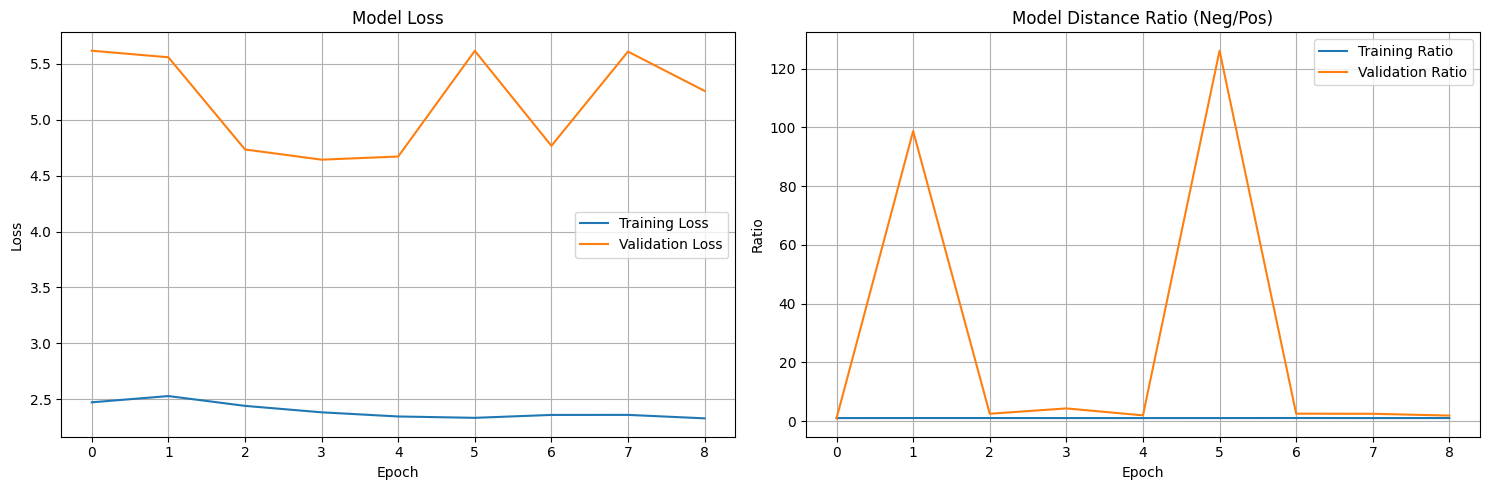

In [23]:
import matplotlib.pyplot as plt


def plot_training_history(history):
    """Plot training history"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot loss
    ax1.plot(history.history["loss"], label="Training Loss")
    ax1.plot(history.history["val_loss"], label="Validation Loss")
    ax1.set_title("Model Loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.legend()
    ax1.grid(True)

    # Plot accuracy
    ax2.plot(history.history["distance_ratio"], label="Training Ratio")
    ax2.plot(history.history["val_distance_ratio"], label="Validation Ratio")
    ax2.set_title("Model Distance Ratio (Neg/Pos)")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Ratio")
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()


# Plot training history
plot_training_history(history)

In [24]:
def evaluate_model(model, test_dataset, threshold=0.5):
    """Evaluate the model on test data"""
    predictions = model.predict(test_dataset)

    # Get true labels
    true_labels = []
    for _, labels in test_dataset:
        true_labels.extend(labels.numpy().flatten())

    true_labels = np.array(true_labels)
    predicted_labels = (predictions.flatten() < threshold).astype(int)

    # Calculate metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    report = classification_report(
        true_labels, predicted_labels, target_names=["Different", "Same"]
    )

    print(f"Test Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(report)

    return predictions, true_labels, predicted_labels

In [25]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


def find_optimal_threshold_roc(model, test_dataset):
    """Find optimal threshold using ROC curve analysis"""
    # Get predictions and true labels
    predictions = model.predict(test_dataset)

    true_labels = []
    for _, labels in test_dataset:
        true_labels.extend(labels.numpy().flatten())

    true_labels = np.array(true_labels)
    distances = predictions.flatten()

    # For ROC curve, we need to invert distances since lower distance = same person
    # Convert distances to similarity scores
    similarities = 1 - distances

    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(true_labels, similarities)
    roc_auc = auc(fpr, tpr)

    # Find optimal threshold (Youden's J statistic)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold_similarity = thresholds[optimal_idx]
    optimal_threshold_distance = 1 - optimal_threshold_similarity

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(
        fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})"
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.scatter(
        fpr[optimal_idx],
        tpr[optimal_idx],
        color="red",
        s=100,
        label=f"Optimal threshold = {optimal_threshold_distance:.3f}",
    )
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve for Threshold Selection")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    return optimal_threshold_distance, roc_auc

In [26]:
def find_threshold_by_accuracy(model, test_dataset, threshold_range=(0.1, 1.5, 100)):
    """Find threshold that maximizes accuracy"""
    # Get predictions and true labels
    predictions = model.predict(test_dataset)

    true_labels = []
    for _, labels in test_dataset:
        true_labels.extend(labels.numpy().flatten())

    true_labels = np.array(true_labels)
    distances = predictions.flatten()

    # Test different thresholds
    thresholds = np.linspace(threshold_range[0], threshold_range[1], threshold_range[2])
    accuracies = []

    for threshold in thresholds:
        predicted_labels = (distances < threshold).astype(int)
        accuracy = accuracy_score(true_labels, predicted_labels)
        accuracies.append(accuracy)

    # Find best threshold
    best_idx = np.argmax(accuracies)
    best_threshold = thresholds[best_idx]
    best_accuracy = accuracies[best_idx]

    # Plot accuracy vs threshold
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, accuracies, "b-", linewidth=2)
    plt.scatter(best_threshold, best_accuracy, color="red", s=100, zorder=5)
    plt.xlabel("Threshold")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs Threshold")
    plt.grid(True)
    plt.axvline(
        x=best_threshold,
        color="red",
        linestyle="--",
        alpha=0.7,
        label=f"Best threshold: {best_threshold:.3f} (Acc: {best_accuracy:.3f})",
    )
    plt.legend()
    plt.show()

    return best_threshold, best_accuracy

In [27]:
def find_eer_threshold(model, test_dataset):
    """Find threshold at Equal Error Rate (EER)"""
    # Get predictions and true labels
    predictions = model.predict(test_dataset)

    true_labels = []
    for _, labels in test_dataset:
        true_labels.extend(labels.numpy().flatten())

    true_labels = np.array(true_labels)
    distances = predictions.flatten()

    # Calculate EER
    similarities = 1 - distances  # Convert to similarities
    fpr, tpr, thresholds = roc_curve(true_labels, similarities)
    fnr = 1 - tpr  # False Negative Rate

    # Find where FPR ≈ FNR (Equal Error Rate)
    eer_idx = np.argmin(np.abs(fpr - fnr))
    eer_threshold_similarity = thresholds[eer_idx]
    eer_threshold_distance = 1 - eer_threshold_similarity
    eer_rate = (fpr[eer_idx] + fnr[eer_idx]) / 2

    # Plot EER
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, fpr, label="False Positive Rate", color="red")
    plt.plot(thresholds, fnr, label="False Negative Rate", color="blue")
    plt.axvline(
        x=eer_threshold_similarity,
        color="green",
        linestyle="--",
        label=f"EER Threshold: {eer_threshold_distance:.3f}",
    )
    plt.xlabel("Threshold (Similarity)")
    plt.ylabel("Error Rate")
    plt.title(f"Equal Error Rate (EER = {eer_rate:.3f})")
    plt.legend()
    plt.grid(True)
    plt.show()

    return eer_threshold_distance, eer_rate

In [28]:
from sklearn.metrics import precision_recall_curve


def find_threshold_precision_recall_robust(model, test_dataset, target_precision=0.95):
    """Find threshold for target precision - robust version"""
    # Get predictions and true labels
    predictions = model.predict(test_dataset)

    true_labels = []
    for _, labels in test_dataset:
        true_labels.extend(labels.numpy().flatten())

    true_labels = np.array(true_labels)
    distances = predictions.flatten()
    similarities = 1 - distances

    # Calculate precision-recall curve
    precision, recall, thresholds = precision_recall_curve(true_labels, similarities)

    print(
        f"Shapes: precision={precision.shape}, recall={recall.shape}, thresholds={thresholds.shape}"
    )

    # Handle the size mismatch (precision/recall have one more element than thresholds)
    if len(precision) == len(thresholds) + 1:
        precision = precision[:-1]
        recall = recall[:-1]

    # Find threshold for target precision
    target_idx = np.where(precision >= target_precision)[0]

    if len(target_idx) > 0:
        # Among points meeting precision requirement, pick the one with highest recall
        best_local_idx = np.argmax(recall[target_idx])
        best_idx = target_idx[best_local_idx]

        if best_idx < len(thresholds):  # Safety check
            target_threshold_similarity = thresholds[best_idx]
            target_threshold_distance = 1 - target_threshold_similarity
            achieved_precision = precision[best_idx]
            achieved_recall = recall[best_idx]

            print(f"Found valid threshold at index {best_idx}")
            print(
                f"Achieved precision: {achieved_precision:.3f}, recall: {achieved_recall:.3f}"
            )
        else:
            print(
                f"Index {best_idx} out of bounds for thresholds array of size {len(thresholds)}"
            )
            target_threshold_distance = 0.5
            achieved_precision = target_precision
            achieved_recall = 0.0
    else:
        print(f"Warning: Could not achieve {target_precision:.2f} precision.")
        print(f"Maximum achieved precision: {precision.max():.3f}")
        target_threshold_distance = 0.1  # Very conservative threshold
        achieved_precision = precision.max()
        achieved_recall = recall[np.argmax(precision)]

    # Plot PR curve
    precision_orig, recall_orig, _ = precision_recall_curve(true_labels, similarities)
    plt.figure(figsize=(10, 6))
    plt.plot(recall_orig, precision_orig, "b-", linewidth=2, label="PR Curve")
    plt.axhline(
        y=target_precision,
        color="red",
        linestyle="--",
        label=f"Target Precision: {target_precision}",
    )

    # Mark the selected point
    if len(target_idx) > 0 and best_idx < len(thresholds):
        plt.scatter(
            achieved_recall,
            achieved_precision,
            color="red",
            s=100,
            zorder=5,
            label=f"Selected: P={achieved_precision:.3f}, R={achieved_recall:.3f}",
        )

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.grid(True)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.show()

    return target_threshold_distance

=== COMPREHENSIVE THRESHOLD ANALYSIS ===

1. ROC Curve Analysis:
10/10 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step


2025-09-09 11:47:07.189244: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


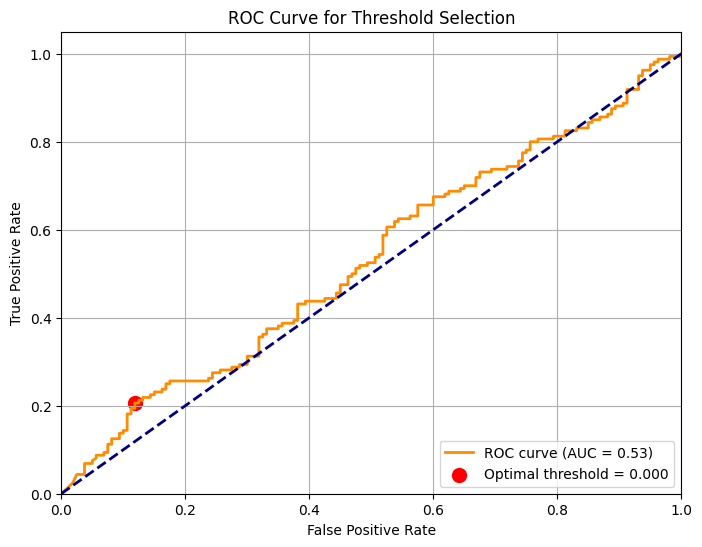

   Optimal threshold: 0.000
   AUC Score: 0.530

2. Accuracy Maximization:
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step


2025-09-09 11:47:23.312019: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


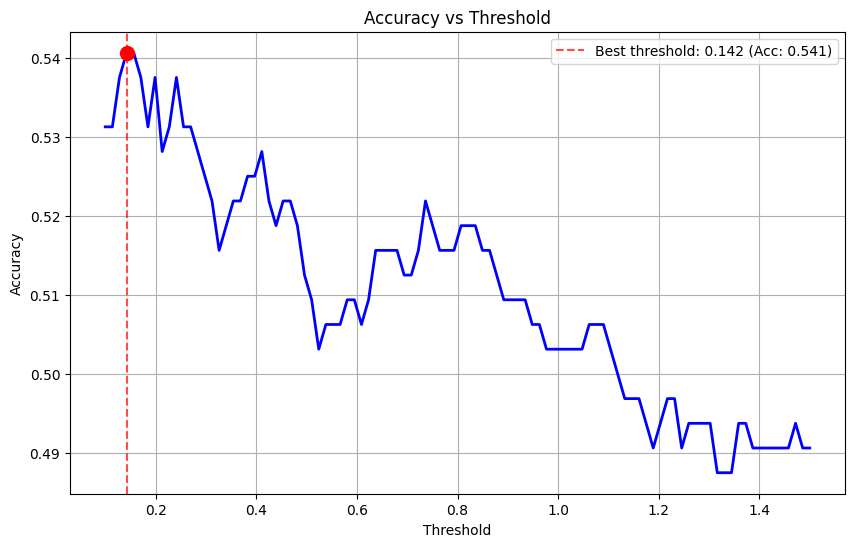

   Best threshold: 0.142
   Best accuracy: 0.541

3. Equal Error Rate:
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step


2025-09-09 11:47:36.151229: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


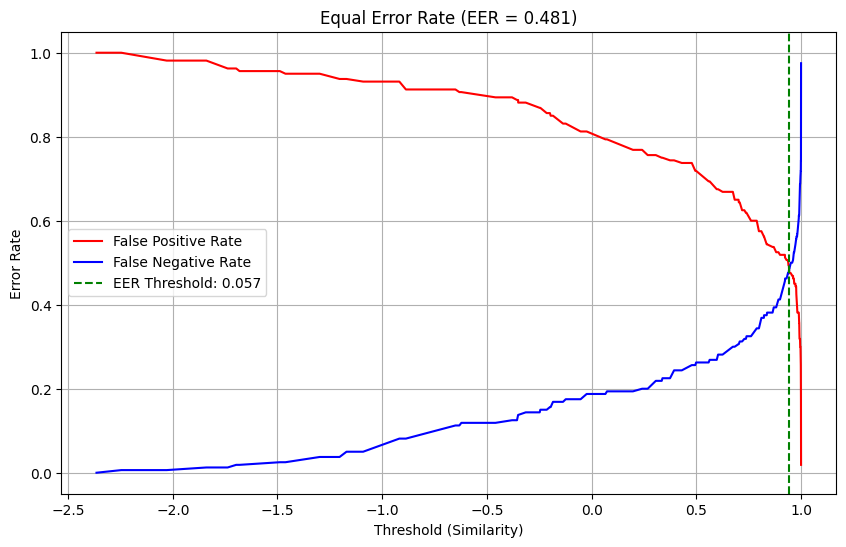

   EER threshold: 0.057
   EER rate: 0.481

4. High Precision (95%):
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step
Shapes: precision=(310,), recall=(310,), thresholds=(309,)
Maximum achieved precision: 0.647


2025-09-09 11:47:50.870231: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


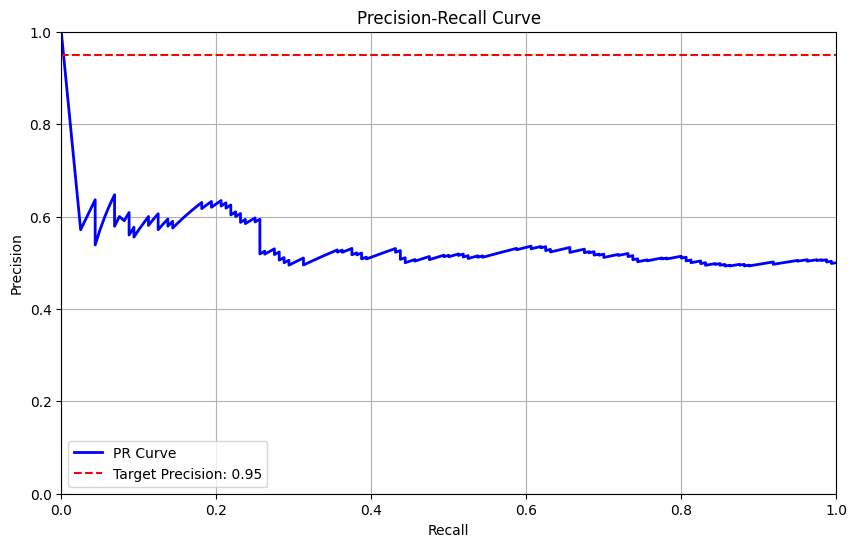

   Threshold: 0.100

=== SUMMARY ===
ROC Optimal:     0.000
Max Accuracy:    0.142
EER:             0.057
95% Precision:   0.100

RECOMMENDED: 0.000 (ROC-based)


In [29]:
def comprehensive_threshold_analysis(model, test_dataset):
    """Comprehensive analysis of different threshold selection methods"""

    print("=== COMPREHENSIVE THRESHOLD ANALYSIS ===\n")

    # Method 1: ROC-based
    print("1. ROC Curve Analysis:")
    roc_threshold, auc_score = find_optimal_threshold_roc(model, test_dataset)
    print(f"   Optimal threshold: {roc_threshold:.3f}")
    print(f"   AUC Score: {auc_score:.3f}\n")

    # Method 2: Accuracy-based
    print("2. Accuracy Maximization:")
    acc_threshold, best_acc = find_threshold_by_accuracy(model, test_dataset)
    print(f"   Best threshold: {acc_threshold:.3f}")
    print(f"   Best accuracy: {best_acc:.3f}\n")

    # Method 3: EER
    print("3. Equal Error Rate:")
    eer_threshold, eer_rate = find_eer_threshold(model, test_dataset)
    print(f"   EER threshold: {eer_threshold:.3f}")
    print(f"   EER rate: {eer_rate:.3f}\n")

    # Method 4: High precision
    print("4. High Precision (95%):")
    pr_threshold = find_threshold_precision_recall_robust(model, test_dataset, 0.95)
    print(f"   Threshold: {pr_threshold:.3f}\n")

    # Summary
    print("=== SUMMARY ===")
    print(f"ROC Optimal:     {roc_threshold:.3f}")
    print(f"Max Accuracy:    {acc_threshold:.3f}")
    print(f"EER:             {eer_threshold:.3f}")
    print(f"95% Precision:   {pr_threshold:.3f}")

    # Recommendation
    print(f"\nRECOMMENDED: {roc_threshold:.3f} (ROC-based)")

    return roc_threshold


# Run comprehensive analysis
recommended_threshold = comprehensive_threshold_analysis(
    cosine_siamese_model, test_dataset
)

In [30]:
test_predictions, test_true, test_pred = evaluate_model(
    cosine_siamese_model, test_dataset, threshold=recommended_threshold
)

10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step
Test Accuracy: 0.5406

Classification Report:
              precision    recall  f1-score   support

   Different       0.52      0.88      0.66       160
        Same       0.63      0.20      0.30       160

    accuracy                           0.54       320
   macro avg       0.58      0.54      0.48       320
weighted avg       0.58      0.54      0.48       320



2025-09-09 11:48:05.339330: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


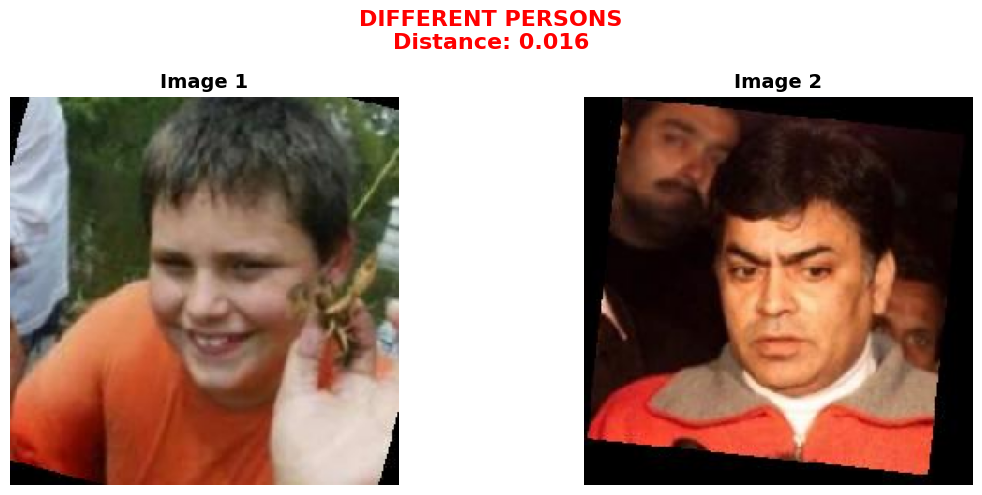

Ground truth: DIFFERENT PERSONS


In [35]:
# get random pair from test set
random_index = random.randint(0, len(test_pairs) - 1)
example_pair = test_pairs[random_index]
are_they_same = test_labels[random_index]
img1_path, img2_path = example_pair
# Compare the two images
result = compare_faces(
    cosine_siamese_model, img1_path, img2_path, threshold=recommended_threshold
)
# Visualize the prediction
visualize_prediction(img1_path, img2_path, result)
print(f"Ground truth: {'SAME PERSON' if are_they_same==1 else 'DIFFERENT PERSONS'}")

2025-09-09 11:49:10.317718: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Positive pairs (same person) distances:
  Mean: 0.014, Std: 0.017
  Range: [0.000, 0.073]
Negative pairs (different people) distances:
  Mean: 0.017, Std: 0.016
  Range: [0.000, 0.050]
Separation gap: 0.003


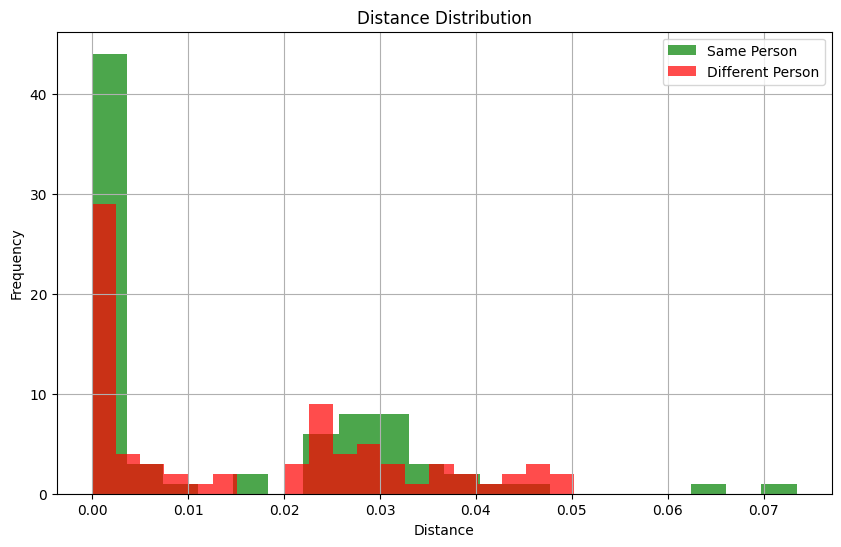

In [32]:
# Check current separation
def analyze_current_separations():
    """Analyze how well current model separates positive vs negative pairs"""

    sample_batch = validation_dataset.take(5)
    all_predictions = []
    all_labels = []

    for (img1, img2), labels in sample_batch:
        predictions = cosine_siamese_model((img1, img2), training=False)
        all_predictions.extend(predictions.numpy().flatten())
        all_labels.extend(labels.numpy().flatten())

    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)

    positive_distances = all_predictions[all_labels == 1]
    negative_distances = all_predictions[all_labels == 0]

    print(f"Positive pairs (same person) distances:")
    print(
        f"  Mean: {positive_distances.mean():.3f}, Std: {positive_distances.std():.3f}"
    )
    print(f"  Range: [{positive_distances.min():.3f}, {positive_distances.max():.3f}]")

    print(f"Negative pairs (different people) distances:")
    print(
        f"  Mean: {negative_distances.mean():.3f}, Std: {negative_distances.std():.3f}"
    )
    print(f"  Range: [{negative_distances.min():.3f}, {negative_distances.max():.3f}]")

    print(
        f"Separation gap: {negative_distances.mean() - positive_distances.mean():.3f}"
    )

    # Plot histogram
    plt.figure(figsize=(10, 6))
    plt.hist(positive_distances, bins=20, alpha=0.7, label="Same Person", color="green")
    plt.hist(
        negative_distances, bins=20, alpha=0.7, label="Different Person", color="red"
    )
    plt.xlabel("Distance")
    plt.ylabel("Frequency")
    plt.title("Distance Distribution")
    plt.legend()
    plt.grid(True)
    plt.show()


analyze_current_separations()